## NBA Clustering Project
### Applying clustering algorithm (Kmeans, Hierarchical, Mean-shift) on NBA dataset

**Ching Hong Fung**

**23/11/2021**

This project looks at different clustering algorithms on an nba player dataset. I have just started data science and want to try out some of the new theories on an area of interest. Please leave a comment if you find my analysis interesting.

### Initialisation
Importing packages and datasets. Carrying out data cleaning and organising. Plotting a few visualisations for initial checking.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objects as go

# Print the current directory
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Dataframe 'players' contains basic information such as name, height, weight, birth_date, etc.
# Dataframe 'stats' contains players' performance metrics over the years
players = pd.read_csv("../input/nba-players-stats/player_data.csv")
stats = pd.read_csv("../input/nba-players-stats/Seasons_Stats.csv")

/kaggle/input/nba-players-stats/Players.csv
/kaggle/input/nba-players-stats/Seasons_Stats.csv
/kaggle/input/nba-players-stats/player_data.csv


In [2]:
# Print the basic overview of 'players' df
print(players.info())
print(players.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4550 entries, 0 to 4549
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        4550 non-null   object 
 1   year_start  4550 non-null   int64  
 2   year_end    4550 non-null   int64  
 3   position    4549 non-null   object 
 4   height      4549 non-null   object 
 5   weight      4544 non-null   float64
 6   birth_date  4519 non-null   object 
 7   college     4248 non-null   object 
dtypes: float64(1), int64(2), object(5)
memory usage: 284.5+ KB
None
                  name  year_start  year_end position height  weight  \
0       Alaa Abdelnaby        1991      1995      F-C   6-10   240.0   
1      Zaid Abdul-Aziz        1969      1978      C-F    6-9   235.0   
2  Kareem Abdul-Jabbar        1970      1989        C    7-2   225.0   
3   Mahmoud Abdul-Rauf        1991      2001        G    6-1   162.0   
4    Tariq Abdul-Wahad        1998      2003        F  

In [3]:
# Print the basic overview of 'stats' df
print(stats.info())
print(stats.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24691 entries, 0 to 24690
Data columns (total 53 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  24691 non-null  int64  
 1   Year        24624 non-null  float64
 2   Player      24624 non-null  object 
 3   Pos         24624 non-null  object 
 4   Age         24616 non-null  float64
 5   Tm          24624 non-null  object 
 6   G           24624 non-null  float64
 7   GS          18233 non-null  float64
 8   MP          24138 non-null  float64
 9   PER         24101 non-null  float64
 10  TS%         24538 non-null  float64
 11  3PAr        18839 non-null  float64
 12  FTr         24525 non-null  float64
 13  ORB%        20792 non-null  float64
 14  DRB%        20792 non-null  float64
 15  TRB%        21571 non-null  float64
 16  AST%        22555 non-null  float64
 17  STL%        20792 non-null  float64
 18  BLK%        20792 non-null  float64
 19  TOV%        19582 non-nul

In [4]:
# Dropping and renaming some columns in player dataframe for simplicity
players.drop(['year_start', 'year_end', 'birth_date', 'college'], axis=1, inplace=True)
players.rename(columns={'name': 'Name', 'position': 'Position', 'height': 'Height', 'weight': 'Weight'}, inplace=True)
players.set_index('Name')

,Position,Height,Weight
Name,,,
Alaa Abdelnaby,F-C,6-10,240.0
Zaid Abdul-Aziz,C-F,6-9,235.0
Kareem Abdul-Jabbar,C,7-2,225.0
Mahmoud Abdul-Rauf,G,6-1,162.0
Tariq Abdul-Wahad,F,6-6,223.0
...,...,...,...
Ante Zizic,F-C,6-11,250.0
Jim Zoet,C,7-1,240.0
Bill Zopf,G,6-1,170.0


In [5]:
# Clean name column by stripping white space
# Removing all duplicated names to avoid confusion
players['Name'].str.strip()
players = players[players['Name'].duplicated(keep=False)!=True]

In [6]:
# Converting heights from feet-inches to centimetres; weight from pounds to kg
conversions = [30.48, 2.54]
players['Height'] = players['Height'].dropna().str.split('-').apply(pd.Series).astype(int).dot(conversions)
players['Weight'] = players['Weight']*0.454
print(players.columns)
print(players.head())

Index(['Name', 'Position', 'Height', 'Weight'], dtype='object')
                  Name Position  Height   Weight
0       Alaa Abdelnaby      F-C  208.28  108.960
1      Zaid Abdul-Aziz      C-F  205.74  106.690
2  Kareem Abdul-Jabbar        C  218.44  102.150
3   Mahmoud Abdul-Rauf        G  185.42   73.548
4    Tariq Abdul-Wahad        F  198.12  101.242


In [7]:
# Restrict the number of attributes wihtin stats dataframe as some games data were 
# not collected in the past; also limit feature set for simplicity
stats.drop(['Unnamed: 0', 'Year', 'Pos', 'Age', 'Tm', 'GS', '3PAr', 'FTr', 'ORB%', 
            'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'blanl', 'OWS', 
            'DWS', 'WS', 'WS/48', 'blank2', 'OBPM', 'DBPM', 'BPM', 'VORP', 'FG', 'FGA', 
            '3P', '3PA', '2P', '2PA', 'FT', 'FTA', 'ORB', 'DRB'],
            axis=1, inplace=True)

In [8]:
# Group by players names spanning multiple teams and years; aggregate the stats appropriately
aggregation_functions = {'GamesPlayed': 'sum', 'MinutesPlayed': 'sum', 'PER': 'mean', 'TS%': 'mean', 
                         'FG%': 'mean', '3P%': 'mean', '2P%': 'mean', 'eFG%': 'mean',
                         'FT%': 'mean', 'TRB': 'sum', 'AST': 'sum', 'STL': 'sum', 
                         'BLK': 'sum', 'TOV': 'sum', 'PF': 'sum', 'PTS': 'sum'}
stats.rename(columns={'Player': 'Name', 'G': 'GamesPlayed', 'MP': 'MinutesPlayed'}, inplace=True)
stats = stats.groupby(by=['Name']).aggregate(aggregation_functions)
stats = stats.reset_index()
print(stats.columns)
print(stats.head())

Index(['Name', 'GamesPlayed', 'MinutesPlayed', 'PER', 'TS%', 'FG%', '3P%',
       '2P%', 'eFG%', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')
            Name  GamesPlayed  MinutesPlayed        PER       TS%       FG%  \
0     A.C. Green       1361.0        39044.0  13.872222  0.543556  0.487667   
1  A.J. Bramlett          8.0           61.0  -0.400000  0.190000  0.190000   
2   A.J. English        151.0         3108.0  11.550000  0.480000  0.436000   
3    A.J. Guyton         80.0         1246.0   4.366667  0.324000  0.255667   
4   A.J. Hammons         22.0          163.0   8.400000  0.472000  0.405000   

        3P%       2P%      eFG%       FT%      TRB     AST     STL    BLK  \
0  0.146833  0.501889  0.493167  0.708056  10129.0  1469.0  1103.0  562.0   
1       NaN  0.190000  0.190000       NaN     22.0     0.0     1.0    0.0   
2  0.136500  0.450500  0.438500  0.774000    315.0   320.0    57.0   24.0   
3  0.255000  0.254000  0.310667  0.824000 

In [9]:
# Combine the players' basic informaiton with their career stats
combined = pd.merge(players, stats, how='outer', on='Name')
print(combined.info())
print(combined.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4655 entries, 0 to 4654
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Name           4655 non-null   object 
 1   Position       4452 non-null   object 
 2   Height         4452 non-null   float64
 3   Weight         4447 non-null   float64
 4   GamesPlayed    3921 non-null   float64
 5   MinutesPlayed  3921 non-null   float64
 6   PER            3763 non-null   float64
 7   TS%            3908 non-null   float64
 8   FG%            3907 non-null   float64
 9   3P%            2457 non-null   float64
 10  2P%            3903 non-null   float64
 11  eFG%           3907 non-null   float64
 12  FT%            3771 non-null   float64
 13  TRB            3921 non-null   float64
 14  AST            3921 non-null   float64
 15  STL            3921 non-null   float64
 16  BLK            3921 non-null   float64
 17  TOV            3921 non-null   float64
 18  PF      

In [10]:
# Display a few players' statistics
combined.loc[combined['Name'] == 'LeBron James']

,Name,Position,Height,Weight,GamesPlayed,MinutesPlayed,PER,TS%,FG%,3P%,2P%,eFG%,FT%,TRB,AST,STL,BLK,TOV,PF,PTS
1920,LeBron James,F-G,203.2,113.5,1061.0,41272.0,27.7,0.5855,0.503571,0.342143,0.546143,0.538929,0.739071,7707.0,7461.0,1749.0,817.0,3619.0,1977.0,28787.0


In [11]:
combined.loc[combined['Name'] == 'Stephen Curry']

,Name,Position,Height,Weight,GamesPlayed,MinutesPlayed,PER,TS%,FG%,3P%,2P%,eFG%,FT%,TRB,AST,STL,BLK,TOV,PF,PTS
860,Stephen Curry,G,190.5,86.26,574.0,19897.0,23.3,0.61225,0.476625,0.439875,0.509375,0.5735,0.891625,2502.0,3916.0,1029.0,121.0,1818.0,1441.0,13088.0


In [12]:
combined.loc[combined['Name'] == 'Kobe Bryant']

,Name,Position,Height,Weight,GamesPlayed,MinutesPlayed,PER,TS%,FG%,3P%,2P%,eFG%,FT%,TRB,AST,STL,BLK,TOV,PF,PTS
520,Kobe Bryant,G-F,198.12,96.248,1346.0,48637.0,21.55,0.5432,0.4414,0.3177,0.47345,0.4762,0.83495,7047.0,6306.0,1944.0,640.0,4010.0,3353.0,33643.0


In [13]:
# Plotting players' height against weight.
fig = go.Figure(data=go.Scatter(x=combined['Weight'],
                                y=combined['Height'],
                                mode='markers',
                                text=combined['Name'],
                                marker=dict(color='#34eb3a')))
fig.update_layout(
    title='NBA Player: Height vs Weight',
    xaxis_title='Weight (kg)',
    yaxis_title='Height (cm)',
    plot_bgcolor='rgba(0,0,0,0)'
)
fig.show()

In [14]:
# Plotting players' points scored vs games played.
fig = go.Figure(data=go.Scatter(x=combined['GamesPlayed'],
                                y=combined['PTS'],
                                mode='markers',
                                text=combined['Name'],
                                marker=dict(color='#34eb3a')))
fig.update_layout(
    title='NBA Player: Points scored vs games played',
    xaxis_title='Games Played',
    yaxis_title='Points Scored',
    plot_bgcolor='rgba(0,0,0,0)'
)
fig.show()

### Mean Normalisation and PCA Dimensionality Reduction
As the combined dataset contiains a range of statistics with different ranges (in particular, the percentages are within the 0-1 range while points could go up to 10000s), we need to mean normalise the data before carrying out PCA reduction.

Principal Component Analysis reduces the dimension of analysis by finding the correlations between attributes.

In [15]:
# Create dataset with no null values (excluding missing statistics)
combinedClean = combined.drop(['Position'], axis=1).dropna().reset_index(drop=True)
combinedClean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2309 entries, 0 to 2308
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Name           2309 non-null   object 
 1   Height         2309 non-null   float64
 2   Weight         2309 non-null   float64
 3   GamesPlayed    2309 non-null   float64
 4   MinutesPlayed  2309 non-null   float64
 5   PER            2309 non-null   float64
 6   TS%            2309 non-null   float64
 7   FG%            2309 non-null   float64
 8   3P%            2309 non-null   float64
 9   2P%            2309 non-null   float64
 10  eFG%           2309 non-null   float64
 11  FT%            2309 non-null   float64
 12  TRB            2309 non-null   float64
 13  AST            2309 non-null   float64
 14  STL            2309 non-null   float64
 15  BLK            2309 non-null   float64
 16  TOV            2309 non-null   float64
 17  PF             2309 non-null   float64
 18  PTS     

In [16]:
# Using the sklearn StandardScalar function to mean normalise the data
# Set mean of each column to zero and standard deviation to 1 ()
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(combinedClean.drop(['Name'], axis=1).values)
print(X.mean(axis=0)) # Close to 0
print(X.std(axis=0)) # Exactly 1

[ 2.75723816e-15 -1.87713759e-16 -7.84705057e-17 -5.84682199e-17
  2.60029715e-16 -2.22333099e-16  1.15397802e-16 -1.40016000e-16
 -1.97714902e-16 -1.76173978e-16 -7.43161848e-16 -6.46227694e-17
  4.23125276e-17 -7.38545936e-17 -3.69272968e-17  7.61625496e-17
  4.61591210e-17 -3.07727473e-18]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [17]:
# Using Principal Component Analysis to reduce the dimensionality of the data 
# in order to better visualise results and optimise the result of the clustering.
from sklearn.decomposition import PCA
pca = PCA(n_components=2) # Choose 2 components to allow easy visualisation
principalComponents = pca.fit_transform(X)
principalComponents

array([[-0.69047711, -1.14214215],
       [ 1.54438656,  1.43822489],
       [-1.36559208,  1.12285508],
       ...,
       [-2.27798241,  0.13445669],
       [-2.0958048 , -0.88154205],
       [-0.69836637, -4.15949833]])

In [18]:
# Creating a dataframe for the PCA components; concatenate the names back to the set
PCA_df = pd.DataFrame(data = principalComponents, columns = ['Component1', 'Component2'] )
PCA_df = pd.concat([combinedClean['Name'],PCA_df], axis=1)
PCA_df.head()

,Name,Component1,Component2
0,Alaa Abdelnaby,-0.690477,-1.142142
1,Mahmoud Abdul-Rauf,1.544387,1.438225
2,Tariq Abdul-Wahad,-1.365592,1.122855
3,Shareef Abdur-Rahim,6.119431,1.266789
4,Tom Abernethy,-0.791292,-0.917446


<Figure size 432x288 with 0 Axes>

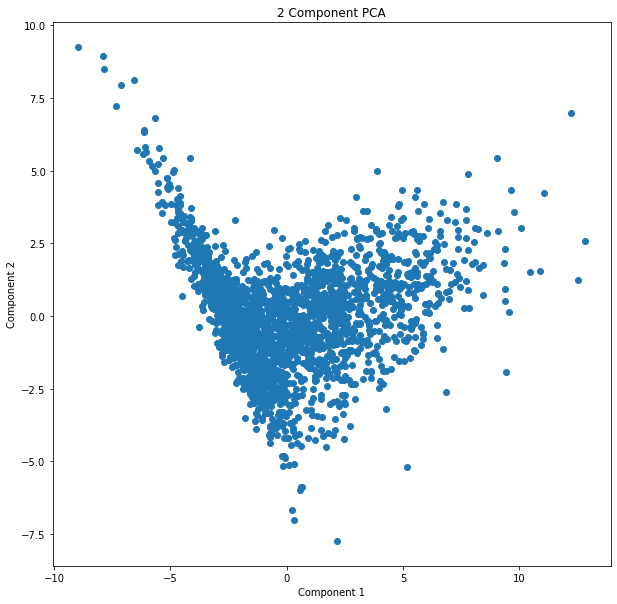

In [19]:
# Plotting out two PCA components from dataset of reduced dimension
plt.figure()
plt.figure(figsize=(10,10))
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('2 Component PCA')
plt.scatter(PCA_df['Component1'], PCA_df['Component2'])

### K-Means Clustering
K-means algorithm has two steps in each iteration. It randomises starting locations of the centroids and assigns data points to each centroid based on shortest Euclidean distance. It then moves the centroids based on the average of the datapoints. The main variable is the number of clusters. It isn't obvious from the plot above how many to go for. I picked 10 as an arbitary number.

In [20]:
# Importing the KMeans algorithm from sklearn.cluster
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters = 10, init = 'k-means++', random_state = 1)
kmeans_model.fit(principalComponents) # Fit the model on our PCA components
kmeans_labels = kmeans_model.labels_ # Get the labels of each cluster

In [21]:
# Merge cluster results with other variables for visualisation
interest_df = combined[['Name', 'PTS']] # Vary the element of interest here
temp = pd.merge(PCA_df, interest_df, how='left', on='Name')
kmeans_results = pd.concat([temp, pd.DataFrame(data=kmeans_labels, columns=['ClusterNumber'])], axis=1)
kmeans_results.head()

,Name,Component1,Component2,PTS,ClusterNumber
0,Alaa Abdelnaby,-0.690477,-1.142142,2299.0,8
1,Mahmoud Abdul-Rauf,1.544387,1.438225,8553.0,9
2,Tariq Abdul-Wahad,-1.365592,1.122855,2662.0,3
3,Shareef Abdur-Rahim,6.119431,1.266789,16412.0,7
4,Tom Abernethy,-0.791292,-0.917446,1842.0,8


In [22]:
# Plotting players' clusters from kmeans.
fig = go.Figure(data=go.Scatter(x=kmeans_results['Component1'],
                                y=kmeans_results['Component2'],
                                mode='markers',
                                text=kmeans_results['PTS'], # Change the text label to see what each cluster represents
                                marker=dict(color=
                                    kmeans_results['ClusterNumber']) # Set colour according to clusters
                               ))
fig.update_layout(
    title='NBA Player: kmeans clusters',
    xaxis_title='Component1',
    yaxis_title='Component2',
    plot_bgcolor='rgba(0,0,0,0)'
)
fig.show()

### Hierarchical Clustering
Hierarchical clustering is an iterative process that joins data points with the shortest distance into clusters. The process repeats until large linkages/clusters are formed. The main variable is the closest distance cutoff instead of the number of clusters. This sets the number of clusters. Again, this could be quite arbitary but the algorithm allows us to handpick the number of clusters while automatically adjusting the cutoff.

Clusters seem very similar to the kmeans clusters with slight differences along the boundaries in the densely populated region. Perhaps picking a higher number of clusters would lead to more refined results.

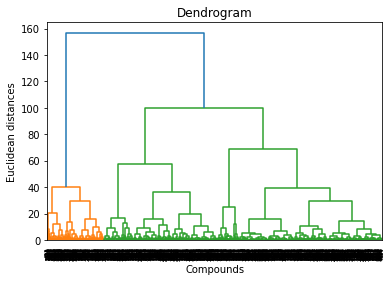

In [23]:
# Importing the dendrogram visualiser to find closest Euclidean distances
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(principalComponents, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Compounds')
plt.ylabel('Euclidean distances')
plt.show()

In [24]:
# Importing the AgglomerativeClustering (hierarchical) algorithm from skleanr.cluster
from sklearn.cluster import AgglomerativeClustering
hc_model = AgglomerativeClustering(n_clusters = 10, affinity = 'euclidean', linkage = 'ward') # Set Euclidean distance
hc_model = hc_model.fit(principalComponents) # Fit the model on our PCA components
hc_labels = hc_model.labels_ # Get the labels of each cluster

In [25]:
# Merge cluster results with other variables for visualisation
interest_df = combined[['Name', 'PTS']] # Vary the element of interest here
temp = pd.merge(PCA_df, interest_df, how='left', on='Name')
hc_results = pd.concat([temp, pd.DataFrame(data=hc_labels, columns=['ClusterNumber'])], axis=1)
hc_results.head()

,Name,Component1,Component2,PTS,ClusterNumber
0,Alaa Abdelnaby,-0.690477,-1.142142,2299.0,1
1,Mahmoud Abdul-Rauf,1.544387,1.438225,8553.0,7
2,Tariq Abdul-Wahad,-1.365592,1.122855,2662.0,8
3,Shareef Abdur-Rahim,6.119431,1.266789,16412.0,2
4,Tom Abernethy,-0.791292,-0.917446,1842.0,1


In [26]:
# Plotting players' clusters from hierarchichal
fig = go.Figure(data=go.Scatter(x=hc_results['Component1'],
                                y=hc_results['Component2'],
                                mode='markers',
                                text=hc_results['PTS'], # Change the text label to see what each cluster represents
                                marker=dict(color=
                                    hc_results['ClusterNumber']) # Set colour according to clusters
                               ))
fig.update_layout(
    title='NBA Player: hierarchical clusters',
    xaxis_title='Component1',
    yaxis_title='Component2',
    plot_bgcolor='rgba(0,0,0,0)'
)
fig.show()

### Mean-Shift Clustering
Mean shift uses a window with a set bandwidth to assign data points to each cluster then subsequently moves the window towards the centroids of each window during iterations. It has an assignment step and a movement step similar to kmeans. The main variable is the bandwidth. As our data seems very densly populated in the middle, I chose an arbitarily small bandwith of 1 in hopes of getting more refined clusters.

Varying the bandwidth would achieve different results but the general trend is that there are 2-3 big clusters in the centre of the plot with just a few smaller cluster on the peripheries.

In [27]:
# Import the MeanShift algorithm from sklearn.cluster
from sklearn.cluster import MeanShift
ms_model = MeanShift(bandwidth=1) # Set the bandwidth for this model
ms_model = ms_model.fit(principalComponents) # Fit the model on our PCA components
ms_labels = ms_model.labels_ # Get the labels of each cluster

In [28]:
# Merge cluster results with other variables for visualisation
interest_df = combined[['Name', 'PTS']] # Vary the element of interest here
temp = pd.merge(PCA_df, interest_df, how='left', on='Name')
ms_results = pd.concat([temp, pd.DataFrame(data=ms_labels, columns=['ClusterNumber'])], axis=1)
ms_results.head()

,Name,Component1,Component2,PTS,ClusterNumber
0,Alaa Abdelnaby,-0.690477,-1.142142,2299.0,1
1,Mahmoud Abdul-Rauf,1.544387,1.438225,8553.0,2
2,Tariq Abdul-Wahad,-1.365592,1.122855,2662.0,0
3,Shareef Abdur-Rahim,6.119431,1.266789,16412.0,7
4,Tom Abernethy,-0.791292,-0.917446,1842.0,1


In [29]:
# Plotting players' clusters from meanshift
fig = go.Figure(data=go.Scatter(x=ms_results['Component1'],
                                y=ms_results['Component2'],
                                mode='markers',
                                text=ms_results['PTS'], # Change the text label to see what each cluster represents
                                marker=dict(color=
                                    ms_results['ClusterNumber']) # Set colour according to clusters
                               ))
fig.update_layout(
    title='NBA Player: mean-shift clusters',
    xaxis_title='Component1',
    yaxis_title='Component2',
    plot_bgcolor='rgba(0,0,0,0)'
)
fig.show()